<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Google-search" data-toc-modified-id="Google-search-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Google search</a></span></li><li><span><a href="#Load-a-Text-Book" data-toc-modified-id="Load-a-Text-Book-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load a Text Book</a></span></li><li><span><a href="#Fine-tune-bi_encoder" data-toc-modified-id="Fine-tune-bi_encoder-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fine-tune bi_encoder</a></span></li></ul></div>

<font size="6.2">NLP BERT Semantic Search with Siamese BERT</font>  

<span class="mark">Semantic search seeks to improve search accuracy by understanding the content of the search query. In contrast to traditional search engines, which only find documents based on lexical matches, semantic search can also find synonyms.</span>

In fact, this type of search makes browsing more complete by understanding almost exactly what the user is trying to ask, instead of simply matching keywords to pages. The idea behind semantic search is to embed all entries in your corpus, which can be sentences, paragraphs, or documents, into a vector space.

Semantic search algorithms used contextual embedding to perform look-ups, providing for closer <span class="mark">cotextual matches</span> than lexical matches

We have two types of search:

1. **Symmetric Search**: documents and queries are roughly the same size and carry the same amount of semantic content: e.g. getting news article titles for a given query

2. **Asymmetric Search**: documents are usually longer than queries and carry larger amounts of semantic content: e.g. getting an entire paragraph from a textbook for answering a QUERY

    
A <span class="mark">siamese **bi-encoder</span>** architecture allows the network to learn embeddings that can be compared using cosine similarity. **Cross-encoder** is traditional BERT model which is slower. 
Bi-encoder encodes query and candidates independently, using a scoring function to compare them. Cross-encoder encodes query-candidate pairs together, capturing their context. <span class="burk">Cross-encoder performs better but is more computationally expensive, while bi-encoder is more efficient but may lack context awareness. Choice depends on task and requirements.</span>
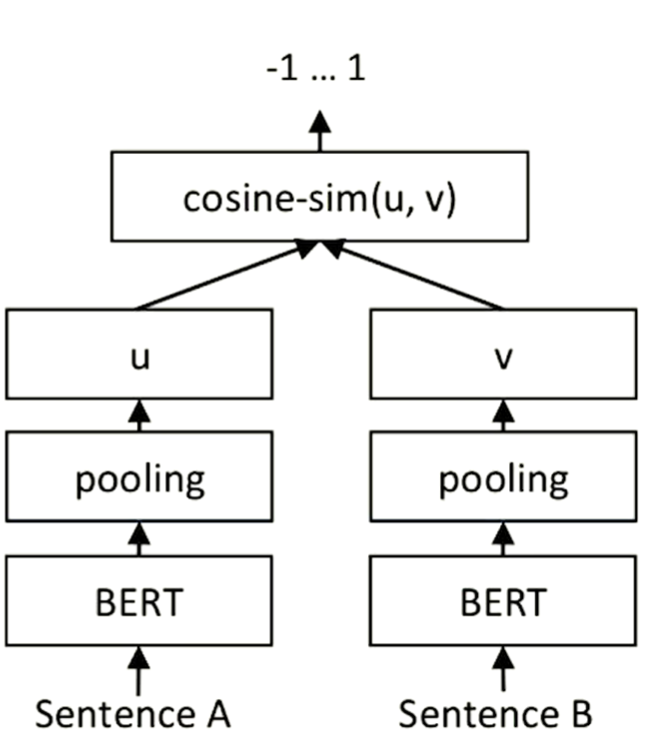

In [1]:
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
from datasets import load_dataset # Load data set from HuggingFace

from sentence_transformers import SentenceTransformer, util # SentenceTransformer for semantic meaning
from transformers import pipeline

from random import sample, seed, shuffle
from sentence_transformers import InputExample, losses, evaluation
from torch.utils.data import DataLoader

# Google search

In [4]:
# We want to search a person on Google

PERSON = 'Mehdi Rezvandehy'

# This is done only for education purposes which is very efficient way of searching
google_html = BeautifulSoup(requests.get(f'https://www.google.com/search?q={PERSON}').text).get_text()[:1024]

nlp = pipeline('QUERY-answering', 
               model='deepset/roberta-base-squad2', 
               tokenizer='deepset/roberta-base-squad2', 
               max_length=20)  # pipline of QUERY-answering with roberta model

nlp(f'Who is {PERSON}?', google_html)

{'score': 0.30398744344711304,
 'start': 284,
 'end': 308,
 'answer': 'Principal Data Scientist'}

# Load a Text Book

In [21]:
# textbook about animal: Title: Wild Animals I Have  Known
text = urlopen("""https://www.gutenberg.org/cache/epub/3031/pg3031.txt""").read().decode() # open URL of the document and read

# split up the text book into paragraphs with new line character and only keep documents of at least 90 characters
doc = list(filter(lambda x: len(x) > 90, text.split('\r\n\r\n')))

doc = np.array(doc)

print(f'There are {len(doc)} paragraphs')

There are 652 paragraphs


In [22]:
# Bi-Encoder is used to encode all the documents, to use asymetric sematic search
bi_encoder = SentenceTransformer('msmarco-distilbert-base-v4') # distilbert was fine-tuned on msmarco data set
bi_encoder.max_seq_length = 256     # Truncate long documents to 256 tokens

bi_encoder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [23]:
# To use the bi-encoe, we can call encode method of the bi_encoder.This takes iterable string of document
# and convert them to tensors
doc_embeddings = bi_encoder.encode(doc, convert_to_tensor=True, show_progress_bar=True)

doc_embeddings.shape

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

torch.Size([652, 768])

In [34]:
QUERY = """What is snare?"""  # a natural language query

In [35]:
# Encode the QUERY using the bi-encoder and convert to a tensor and find relevant documents
que_embedding = bi_encoder.encode(QUERY, convert_to_tensor=True)

# Give number of documents to retrieve with the bi-encoder
cos_sim_score = util.semantic_search(que_embedding, doc_embeddings, top_k=3)[0]

cos_sim_score

[{'corpus_id': 559, 'score': 0.5096046924591064},
 {'corpus_id': 12, 'score': 0.4676859676837921},
 {'corpus_id': 573, 'score': 0.4107315242290497}]

In [36]:
print(f'QUERY: {QUERY}\n')

for i, hit in enumerate(cos_sim_score):
    
    print(f'Document {i + 1} Cos_Sim {hit["score"]:.3f}:\n\n{doc[hit["corpus_id"]]}')
    print('\n')

Question: when Redruff's mother came?

Document 1 Cos_Sim 0.510:

Redruff's mother knew it was coming as soon as she saw the frost grapes
blackening, and the maples shedding their crimson and gold. There was
nothing to do but care for their health and keep them in the quietest
part of the woods.


Document 2 Cos_Sim 0.468:

Redruff really lived in the Don Valley north of Toronto, and many of my
companions will remember him. He was killed in 1889, between the Sugar
Loaf and Castle Frank, by a creature whose name I have withheld, as it
is the species, rather than the individual, that I wish to expose.


Document 3 Cos_Sim 0.411:

Redruff skimmed to her side, terribly frightening the bright-eyed
downlings, and was just a little dashed to find the brood with claims
far stronger than his own. But he soon accepted the change, and
thenceforth joined himself to the brood, caring for them as his father
never had for him.




In [38]:
# answer the QUERY from the top document
nlp(QUERY, str(doc[cos_sim_score[0]['corpus_id']]))

{'score': 0.008875297382473946,
 'start': 36,
 'end': 71,
 'answer': 'as soon as she saw the frost grapes'}

In [40]:
last_example['context']

'Some high-speed black-and-white films, such as Ilford Delta 3200 and Kodak T-MAX P3200, are marketed with film speeds in excess of their true ISO speed as determined using the ISO testing method. For example, the Ilford product is actually an ISO 1000 film, according to its data sheet. The manufacturers do not indicate that the 3200 number is an ISO rating on their packaging. Kodak and Fuji also marketed E6 films designed for pushing (hence the "P" prefix), such as Ektachrome P800/1600 and Fujichrome P1600, both with a base speed of ISO 400.'

We just built an open book **"Open Book Q/A" System**

In [60]:
# load up the adversarial_qa dataset from the Q/A use-case Hugging Face
training_qa = load_dataset('adversarial_qa', 'adversarialQA', split='train')

good_training_data = []
bad_training_data = []

# Loop over adversarial_qa data set. If the context is not the same as the previous context
#, it is going to append to bad training data
#, 
last_example = None
for example in training_qa:
    if last_example and example['context'] != last_example['context']:
        bad_training_data.append((example['QUERY'], last_example['context'], 0.0))  #  add neutral examples
    # QUERY, context, label is 1 if should be matched together
    elif last_example and example['context'] == last_example['context']:
        good_training_data.append((example['QUERY'], example['context'], 1.0))
    last_example = example

Found cached dataset adversarial_qa (C:/Users/mrezv/.cache/huggingface/datasets/adversarial_qa/adversarialQA/1.0.0/92356be07b087c5c6a543138757828b8d61ca34de8a87807d40bbc0e6c68f04b)


This data set was supposed to be used to fine-tune Q/A system
 https://huggingface.co/datasets/adversarial_qa/viewer/adversarialQA/train?row=98

In [61]:
len(good_training_data), len(bad_training_data)

(27352, 2647)

In [63]:
good_training_data[0]

('What is surrounded by cerebrospinal fluid?',
 'Another approach to brain function is to examine the consequences of damage to specific brain areas. Even though it is protected by the skull and meninges, surrounded by cerebrospinal fluid, and isolated from the bloodstream by the blood–brain barrier, the delicate nature of the brain makes it vulnerable to numerous diseases and several types of damage. In humans, the effects of strokes and other types of brain damage have been a key source of information about brain function. Because there is no ability to experimentally control the nature of the damage, however, this information is often difficult to interpret. In animal studies, most commonly involving rats, it is possible to use electrodes or locally injected chemicals to produce precise patterns of damage and then examine the consequences for behavior.',
 1.0)

For this example, we want to have cosign similarity between the embedding of QUERY and answer to be 1.

In [64]:
bad_training_data[0]

('What do you think with?',
 'Another approach to brain function is to examine the consequences of damage to specific brain areas. Even though it is protected by the skull and meninges, surrounded by cerebrospinal fluid, and isolated from the bloodstream by the blood–brain barrier, the delicate nature of the brain makes it vulnerable to numerous diseases and several types of damage. In humans, the effects of strokes and other types of brain damage have been a key source of information about brain function. Because there is no ability to experimentally control the nature of the damage, however, this information is often difficult to interpret. In animal studies, most commonly involving rats, it is possible to use electrodes or locally injected chemicals to produce precise patterns of damage and then examine the consequences for behavior.',
 0.0)

For this example, we want to have cosign similarity between the embedding of QUERY and answer to be 0 which is neutral.

In [65]:
# https://www.sbert.net/docs/training/overview.html for more information on training

seed(42)  # seed our upcoming sample

sampled_training_data = sample(good_training_data, 500) + sample(bad_training_data, 500)

shuffle(sampled_training_data)  # shuffle our data around

training_index = int(.8 * len(sampled_training_data))  # Get an 80/20 train/test split

In [66]:
# Define the training examples; that is how the library is designed.
train_examples = [InputExample(texts=t[:2], label=t[2]) for t in sampled_training_data[:training_index]]

train_examples[0].__dict__

{'guid': '',
 'texts': ("What was hoped to see a friend, and why didn't it happen?",
  'Chen states that the fourth Dalai Lama Yonten Gyatso was granted the title "Master of Vajradhara" and an official seal by the Wanli Emperor in 1616. This was noted in the Biography of the Fourth Dalai Lama, which stated that one Soinam Lozui delivered the seal of the Emperor to the Dalai Lama. The Wanli Emperor had invited Yonten Gyatso to Beijing in 1616, but just like his predecessor he died before being able to make the journey.'),
 'label': 1.0}

We have not used dataloader, we used data collator before: **A data loader is the object that specifically shuffles/grabs batches of data from a Dataset**


In [72]:
# Define the train dataset, a dataloader and the train loss
# We don't usually have to explicitly create one using the Trainer because it has a default loader built in
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32,collate_fn=bi_encoder.smart_batching_collate)

# We have to explicitly define our loss
train_loss = losses.CosineSimilarityLoss(bi_encoder)

In [73]:
(QUERY_batch, context_batch), labels = next(iter(train_dataloader))  # get a sample batch of data

QUERY_batch['input_ids'].shape, context_batch['input_ids'].shape, labels.shape

(torch.Size([32, 30]), torch.Size([32, 256]), torch.Size([32]))

256 came from `bi_encoder.max_seq_length = 256`, it is truncating any length > 256. 

In [77]:
# Evaluation data, sentences1 and sentences2 are lists of QUERYs and context respectively and scores are 0 or 1
sentences1, sentences2, scores = zip(*sampled_training_data[training_index:])

# evaluator will evaluate embedding closeness
evaluator = evaluation.EmbeddingSimilarityEvaluator(sentences1, sentences2, scores)

In [78]:
bi_encoder.evaluate(evaluator)  # initial evalaution (higher embedding similarity is better)


0.5102074536940308

# Fine-tune bi_encoder

In [83]:
# Fine-tune the model using the fit method using bi_encoder.fit
bi_encoder.fit(
    train_objectives=[(train_dataloader, train_loss)], 
    output_path='ir/results',
    epochs=2, 
    evaluator=evaluator
)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration:   0%|          | 0/25 [00:00<?, ?it/s]

In [84]:
bi_encoder.evaluate(evaluator)  # final evalaution (higher embedding similarity is better)
# Not a huge jump in performance with 2 epochs. We could try more data or more epochs

0.5110735332283951

In [85]:
# load fine-tuned IR model
finetuned_bi_encoder = SentenceTransformer('ir/results')

In [88]:
# Slightly more confident results!

document_embeddings = finetuned_bi_encoder.encode(doc, convert_to_tensor=True, show_progress_bar=True)

QUERY_embedding = finetuned_bi_encoder.encode(QUERY, convert_to_tensor=True)

# Get document cos_sim_score
cos_sim_score = util.semantic_search(QUERY_embedding, document_embeddings, top_k=3)[0]

print(f'QUERY: {QUERY}\n')

for i, hit in enumerate(cos_sim_score):
    
    print(f'Document {i + 1} Cos_Sim {hit["score"]:.3f}:\n\n{doc[hit["corpus_id"]]}')
    print('\n')

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Question: when Redruff's mother came?

Document 1 Cos_Sim 0.510:

Redruff's mother knew it was coming as soon as she saw the frost grapes
blackening, and the maples shedding their crimson and gold. There was
nothing to do but care for their health and keep them in the quietest
part of the woods.


Document 2 Cos_Sim 0.468:

Redruff really lived in the Don Valley north of Toronto, and many of my
companions will remember him. He was killed in 1889, between the Sugar
Loaf and Castle Frank, by a creature whose name I have withheld, as it
is the species, rather than the individual, that I wish to expose.


Document 3 Cos_Sim 0.413:

Redruff skimmed to her side, terribly frightening the bright-eyed
downlings, and was just a little dashed to find the brood with claims
far stronger than his own. But he soon accepted the change, and
thenceforth joined himself to the brood, caring for them as his father
never had for him.




In [ ]:
def gutenberg_to_documents(gutenberg_url, bi_encoder):
    text = urlopen(gutenberg_url).read().decode()
    documents = np.array(list(filter(lambda x: len(x) > 100, text.split('\r\n\r\n'))))
    print(f'There are {len(documents)} documents/paragraphs')
    return documents, bi_encoder.encode(documents)

def retrieve_relevant_documents(bi_encoder, query, documents, document_embeddings, cos_sim_score=3):
    query_embedding = bi_encoder.encode(query, convert_to_tensor=True)

    cos_sim_score = util.semantic_search(query_embedding, document_embeddings, top_k=cos_sim_score)[0]

    for i, hit in enumerate(cos_sim_score):
        print(f'Document {i + 1} Cos_Sim {hit["score"]:.3f}:\n\n{documents[hit["corpus_id"]]}')
        print('\n')
    print(f"Answer from Top Document: {nlp(query, str(documents[cos_sim_score[0]['corpus_id']]))}")

In [ ]:
banks_to_bassoon_documents, banks_to_bassoon_embeddings = gutenberg_to_documents(
    'https://www.gutenberg.org/cache/epub/27480/pg27480.txt', finetuned_bi_encoder
)

In [ ]:
retrieve_relevant_documents(finetuned_bi_encoder,
    'What is a banshee?', banks_to_bassoon_documents, banks_to_bassoon_embeddings, 2
)

In [ ]:
retrieve_relevant_documents(finetuned_bi_encoder,
    'When was the Imperial Bank of Germany founded?', banks_to_bassoon_documents, banks_to_bassoon_embeddings, 2
)